# load data

In [54]:
import pandas as pd

df = pd.read_parquet('../results/kis_viability.parquet')

# add drug-cell line combo
df['drug_cell_group'] = df['drug'] + "_" + df['depmap_id']

print('unique drugs:', df['drug'].nunique())
print('unique concs:', df['concentration_M'].nunique())
print('unique cell lines:', df['depmap_id'].nunique())
print('unique drug-cell line combos:', df['drug_cell_group'].nunique())

df

unique drugs: 168
unique concs: 8
unique cell lines: 480
unique drug-cell line combos: 76356


,drug,concentration_M,depmap_id,viability,inh_AAK1,inh_ABL1,inh_ABL2,inh_ACVR1,inh_ACVR1B,inh_ACVR2B,...,inh_TNIK,inh_TNK1,inh_TNK2,inh_TP53RK,inh_TTK,inh_TYK2,inh_ULK1,inh_WEE1,inh_YES1,drug_cell_group
0,AC-480,3.000000e-09,ACH-000007,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,AC-480_ACH-000007
1,AC-480,3.000000e-09,ACH-000008,1.088750,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,AC-480_ACH-000008
2,AC-480,3.000000e-09,ACH-000011,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,AC-480_ACH-000011
3,AC-480,3.000000e-09,ACH-000012,1.298190,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,AC-480_ACH-000012
4,AC-480,3.000000e-09,ACH-000013,1.458047,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,AC-480_ACH-000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610843,Y-39983,3.000000e-05,ACH-001239,-0.038812,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Y-39983_ACH-001239
610844,Y-39983,3.000000e-05,ACH-001306,1.784841,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Y-39983_ACH-001306
610845,Y-39983,3.000000e-05,ACH-001307,1.000000,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Y-39983_ACH-001307
610846,Y-39983,3.000000e-05,ACH-001318,1.876079,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Y-39983_ACH-001318


# 10 fold cv grouped by drug-cell line combo

100%|██████████| 10/10 [03:37<00:00, 21.76s/it]

Random Forest
	mean: 0.18646660994327163
	std: 0.13682667698977416
XGBoost
	mean: 0.18442454917882958
	std: 0.13597742063380044


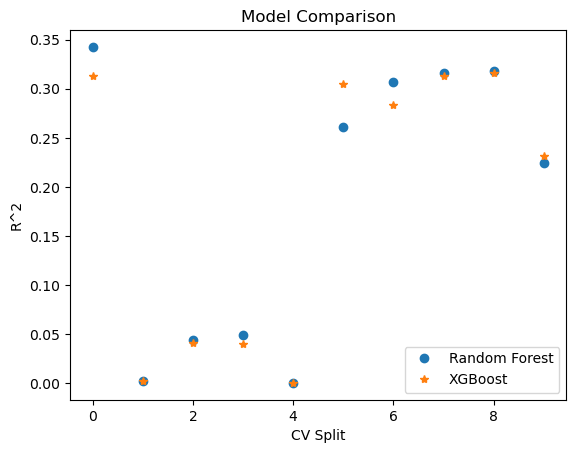

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# X, y, and grouping
X = df.drop(columns=['drug', 'concentration_M',	'depmap_id', 'viability', 'drug_cell_group'])
y = df['viability']
groups = df['drug_cell_group']
gkf = GroupKFold(n_splits=10)

# cv loop
scores_rf = []
scores_xgb = []
for train_index, test_index in tqdm.tqdm(gkf.split(X, y, groups=groups), total=gkf.get_n_splits(X, y, groups=groups)):
    # X, y
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    # model RF
    model_rf = RandomForestRegressor(n_jobs=-1)
    model_rf.fit(X_train, y_train)
    # predict
    y_pred_rf = model_rf.predict(X_test)
    # score
    score_rf = model_rf.score(X_test, y_test)
    scores_rf.append(score_rf)

    # model XGB
    model_xgb = XGBRegressor(n_jobs=-1)
    model_xgb.fit(X_train, y_train)
    # predict
    y_pred_xgb = model_xgb.predict(X_test)
    # score
    score_xgb = model_xgb.score(X_test, y_test)
    scores_xgb.append(score_xgb)

scores_rf = np.array(scores_rf)
scores_xgb = np.array(scores_xgb)

print('Random Forest')
print('\tmean:', scores_rf.mean())
print('\tstd:', scores_rf.std())

print('XGBoost')
print('\tmean:', scores_xgb.mean())
print('\tstd:', scores_xgb.std())

plt.plot(scores_rf, 'o', label='Random Forest')
plt.plot(scores_xgb, '*', label='XGBoost')
plt.xlabel('CV Split')
plt.ylabel('R^2')
plt.title('Model Comparison')
plt.legend()
plt.show()

# RF model from paper
# model = RandomForestRegressor(n_estimators=500, max_features=22, min_samples_leaf=5, n_jobs=-1)

# equivalent, but slower
# from sklearn.model_selection import cross_val_score
# scores_rf = cross_val_score(RandomForestRegressor(n_jobs=-1), X, y, groups=groups, cv=gkf)
# scores_xgb = cross_val_score(XGBRegressor(n_jobs=-1), X, y, groups=groups, cv=gkf)

# OLD

cv: leave one drug out

In [ ]:
# from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GroupKFold, cross_val_score

# # X, y, and grouing
# X = df.drop(columns=['drug', 'concentration_M',	'depmap_id', 'viability'])
# y = df['viability']
# groups = df['drug']
# logo = LeaveOneGroupOut()

# # model
# model = RandomForestRegressor(n_estimators=500,   # Number of trees
#                               max_features=22,    # Number of predictors to consider at each split
#                               min_samples_leaf=5, # Minimal node size (minimum samples required at a leaf node)
#                               n_jobs=100)#-1)

# # cross validation
# scores = cross_val_score(model, X, y, groups=groups, cv=logo, verbose=1, n_jobs=190-100)#-1)

# # manual cv
# from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.ensemble import RandomForestRegressor
# import tqdm

# # X, y, and grouing
# X = df.drop(columns=['drug', 'concentration_M',	'depmap_id', 'viability'])
# y = df['viability']
# groups = df['drug']
# logo = LeaveOneGroupOut()

# scores_manual = []
# # loop
# for train_index, test_index in tqdm.tqdm(logo.split(X, y, groups=groups), total=logo.get_n_splits(X, y, groups=groups)):
#     # X, y
#     X_train = X.iloc[train_index]
#     X_test = X.iloc[test_index]
#     y_train = y.iloc[train_index]
#     y_test = y.iloc[test_index]

#     # model
#     # model = RandomForestRegressor(n_jobs=-1)
#     model = RandomForestRegressor(n_estimators=500, max_features=22, min_samples_leaf=5, n_jobs=-1)#-1)
#     model.fit(X_train, y_train)
#     # predict
#     y_pred = model.predict(X_test)

#     # score
#     score = model.score(X_test, y_test)
#     scores_manual.append(score)

# # # add group
# # group = []
# # assert len(set(groups.iloc[test_index].values)) == 1
# # group.append(groups.iloc[test_index].values[0])

[Parallel(n_jobs=90)]: Using backend LokyBackend with 90 concurrent workers.
[Parallel(n_jobs=90)]: Done 158 out of 168 | elapsed: 236.4min remaining: 15.0min
[Parallel(n_jobs=90)]: Done 168 out of 168 | elapsed: 236.5min finished


cv:
	mean score: -0.33448219120847356
	std score : 0.9869840688376418
